# Programmation par contrainte: évaluation pratique 5-SDBD + mastère VALDOM, INSA Toulouse, janvier 2023


In [1]:
from docplex.cp.model import *
from docplex.cp.config import get_default
import matplotlib.pyplot as plt
import random
from config import setup
setup()

## Première partie


##### 1. Proposez un modèle de programmation par contrainte pour trouver un mariage stable. Le modèle peut inclure des contraintes logiques (par exemple if_then). L’utilisation de ce genre de contraintes est accessible dans la documentation du solveur. Utilisez la recherche en profondeur par défaut ((’DepthFirst’) sans préciser des heuristiques de branchements. N’affichez pas les traces d’exécutions internes du solveur

In [9]:
def simple_stable_mariage(mdl, F, H, L):
    #Lpos[i,j] postition de j dans L(i) (facilite le traitement)
    def preprocess(H,F,L):
        LPos = {}
        for h in H:
            for f in F:
                LPos[h,f]=L[h].index(f)
                LPos[f,h]=L[f].index(h)
        return LPos
    
    LPos = preprocess(H,F,L) 
    #x[h,f] mariage entre h et f
    x = {}
    for h in H:
        for f in F:
            x[h,f]=mdl.binary_var(name="x_" + h + "_" + f)

    #D[i] cout du marriage de i (Position de son partenaire dans L(i))
    D = {}
    for i in H+F:
        D[i]=mdl.integer_var(name="D_"+i)


    #Ajout des contraintes
    #Contrainte de monogamie :
    for h in H:
        mdl.add(sum([x[h,f] for f in F])==1)
    for f in F:
        mdl.add(sum([x[h,f] for h in H])==1)


    #Valeur de D (Position du partenaire dans le classement) :
    for h in H:
        mdl.add(D[h]==sum([(x[h,f]*LPos[h,f]) for f in F]))
    for f in F:
        mdl.add(D[f]==sum([(x[h,f]*LPos[f,h]) for h in H]))

    #Couple bloquant =
    #(h,f) est un couple bloquant si 
    #   - le partenaire actuel de h et en plus haute postion de preference que f
    #   - et le partenaire actuel de f et en plus haute postion de preference que h
    for h in H:
        for f in F:
            mdl.add(((D[h]>LPos[h,f]) & (D[f]>LPos[f,h]))==false())

    return x, D


In [5]:
def print_solution(solution,x,D):
    print("\n   SOLUTION :\n")
    for h in H:
        for f in F:
            if(solution[x[h,f]]==1):
                print("Mariage entre ",h," et ",f," (Couts = ",solution[D[h]],solution[D[f]],")")

##### 2. Testez le modèle avec l’exemple ci-dessus (ou un autre exemple) en affichant toutes les solutions. Affichez chaque solution avec un format que vous jugez compréhensible

In [6]:
mdl = CpoModel(name="Mariages")

F = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
H = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']

L= {'h1': ['f1', 'f3', 'f6', 'f2', 'f4', 'f5'],
    'h2': ['f4', 'f6', 'f1', 'f2', 'f5', 'f3'],
    'h3': ['f1', 'f4', 'f5', 'f3', 'f6', 'f2'],
    'h4': ['f6', 'f5', 'f3', 'f4', 'f2', 'f1'],
    'h5': ['f2', 'f3', 'f1', 'f4', 'f5', 'f6'],
    'h6': ['f3', 'f1', 'f2', 'f6', 'f5', 'f4'],
    'f1': ['h1', 'h5', 'h6', 'h3', 'h2', 'h4'],
    'f2': ['h2', 'h4', 'h6', 'h1', 'h3', 'h5'],
    'f3': ['h4', 'h3', 'h6', 'h2', 'h5', 'h1'],
    'f4': ['h1', 'h3', 'h5', 'h4', 'h2', 'h6'],
    'f5': ['h3', 'h2', 'h6', 'h1', 'h4', 'h5'],
    'f6': ['h5', 'h1', 'h3', 'h6', 'h4', 'h2']}

x, D = simple_stable_mariage(mdl,F,H,L)

lsol = mdl.start_search(SearchType="DepthFirst",trace_log=False)

for solution in lsol:
    print_solution(solution,x,D)



   SOLUTION :

Mariage entre  h1  et  f1  (Couts =  0 0 )
Mariage entre  h2  et  f2  (Couts =  3 0 )
Mariage entre  h3  et  f4  (Couts =  1 1 )
Mariage entre  h4  et  f6  (Couts =  0 4 )
Mariage entre  h5  et  f5  (Couts =  4 5 )
Mariage entre  h6  et  f3  (Couts =  0 2 )

   SOLUTION :

Mariage entre  h1  et  f1  (Couts =  0 0 )
Mariage entre  h2  et  f2  (Couts =  3 0 )
Mariage entre  h3  et  f4  (Couts =  1 1 )
Mariage entre  h4  et  f3  (Couts =  2 0 )
Mariage entre  h5  et  f6  (Couts =  5 0 )
Mariage entre  h6  et  f5  (Couts =  4 2 )

   SOLUTION :

Mariage entre  h1  et  f1  (Couts =  0 0 )
Mariage entre  h2  et  f2  (Couts =  3 0 )
Mariage entre  h3  et  f4  (Couts =  1 1 )
Mariage entre  h4  et  f5  (Couts =  1 4 )
Mariage entre  h5  et  f6  (Couts =  5 0 )
Mariage entre  h6  et  f3  (Couts =  0 2 )


##### 3. Proposez deux stratégies de recherches différentes qui vous semblent très différentes (i.e., deux combinaisons de type <heuristique de choix de variables + heuristique de choix de valeurs>). On note ces deux stratégies par S1 et S2

In [7]:
vars = [i for i in x.values()]+[i for i in D.values()]
strats = {}
strats["S1"] = mdl.search_phase(vars,varchooser=mdl.select_random_var(), valuechooser=mdl.select_smallest(value()))
strats["S2"] = mdl.search_phase(vars,varchooser=mdl.select_random_var(), valuechooser=mdl.select_random_value())


On veut tester S1 et S2 avec une recherche en profondeur sans et avec redémarrage (’DepthFirst’ vs ’Restart’). Voici le protocole de l’étude expérimentale :
* Générez différentes instances randomisées du problème avec différentes tailles (à partir de n = 5). Pour
chaque taille, générez 5 instances.

In [3]:
#H,F liste des agents
#L[I] préférences de l'agent I

def create_random_problem(n):
    F = []
    H = []
    for i in range(1,n+1):
        F.append('f'+str(i))
        H.append('h'+str(i))

    L= {}
    for f in F:
        pref = list(H)
        random.shuffle(pref)
        L[f]=pref
    for h in H:
        pref = list(F)
        random.shuffle(pref)
        L[h]=pref
    
    return  F, H, L



In [19]:
instances = {}   
sizes = [5,10,15,20,25,30]
for N in  sizes:
    for I in  range(0,5):
        instances[N,I] = create_random_problem(N)

* Lancez les 4 expérimentations (S1 et S2 avec une recherche en profondeur sans et avec redémarrage) avec
vos jeux de données. Fixez le temps limite à 200s pour chaque exécution 1.


Instance 0 strat S1 DepthFirst [Taille = 5 ]
Instance 0 strat S1 DepthFirst [Taille = 10 ]
Instance 0 strat S1 DepthFirst [Taille = 15 ]
Instance 0 strat S1 DepthFirst [Taille = 20 ]
Instance 0 strat S1 DepthFirst [Taille = 25 ]
Instance 0 strat S1 DepthFirst [Taille = 30 ]
Instance 0 strat S2 DepthFirst [Taille = 5 ]
Instance 0 strat S2 DepthFirst [Taille = 10 ]
Instance 0 strat S2 DepthFirst [Taille = 15 ]
Instance 0 strat S2 DepthFirst [Taille = 20 ]
Instance 0 strat S2 DepthFirst [Taille = 25 ]
Instance 0 strat S2 DepthFirst [Taille = 30 ]
Instance 1 strat S1 DepthFirst [Taille = 5 ]
Instance 1 strat S1 DepthFirst [Taille = 10 ]
Instance 1 strat S1 DepthFirst [Taille = 15 ]
Instance 1 strat S1 DepthFirst [Taille = 20 ]
Instance 1 strat S1 DepthFirst [Taille = 25 ]
Instance 1 strat S1 DepthFirst [Taille = 30 ]
Instance 1 strat S2 DepthFirst [Taille = 5 ]
Instance 1 strat S2 DepthFirst [Taille = 10 ]
Instance 1 strat S2 DepthFirst [Taille = 15 ]
Instance 1 strat S2 DepthFirst [Taille

Text(0.5, 0.98, 'Restart searchtype')

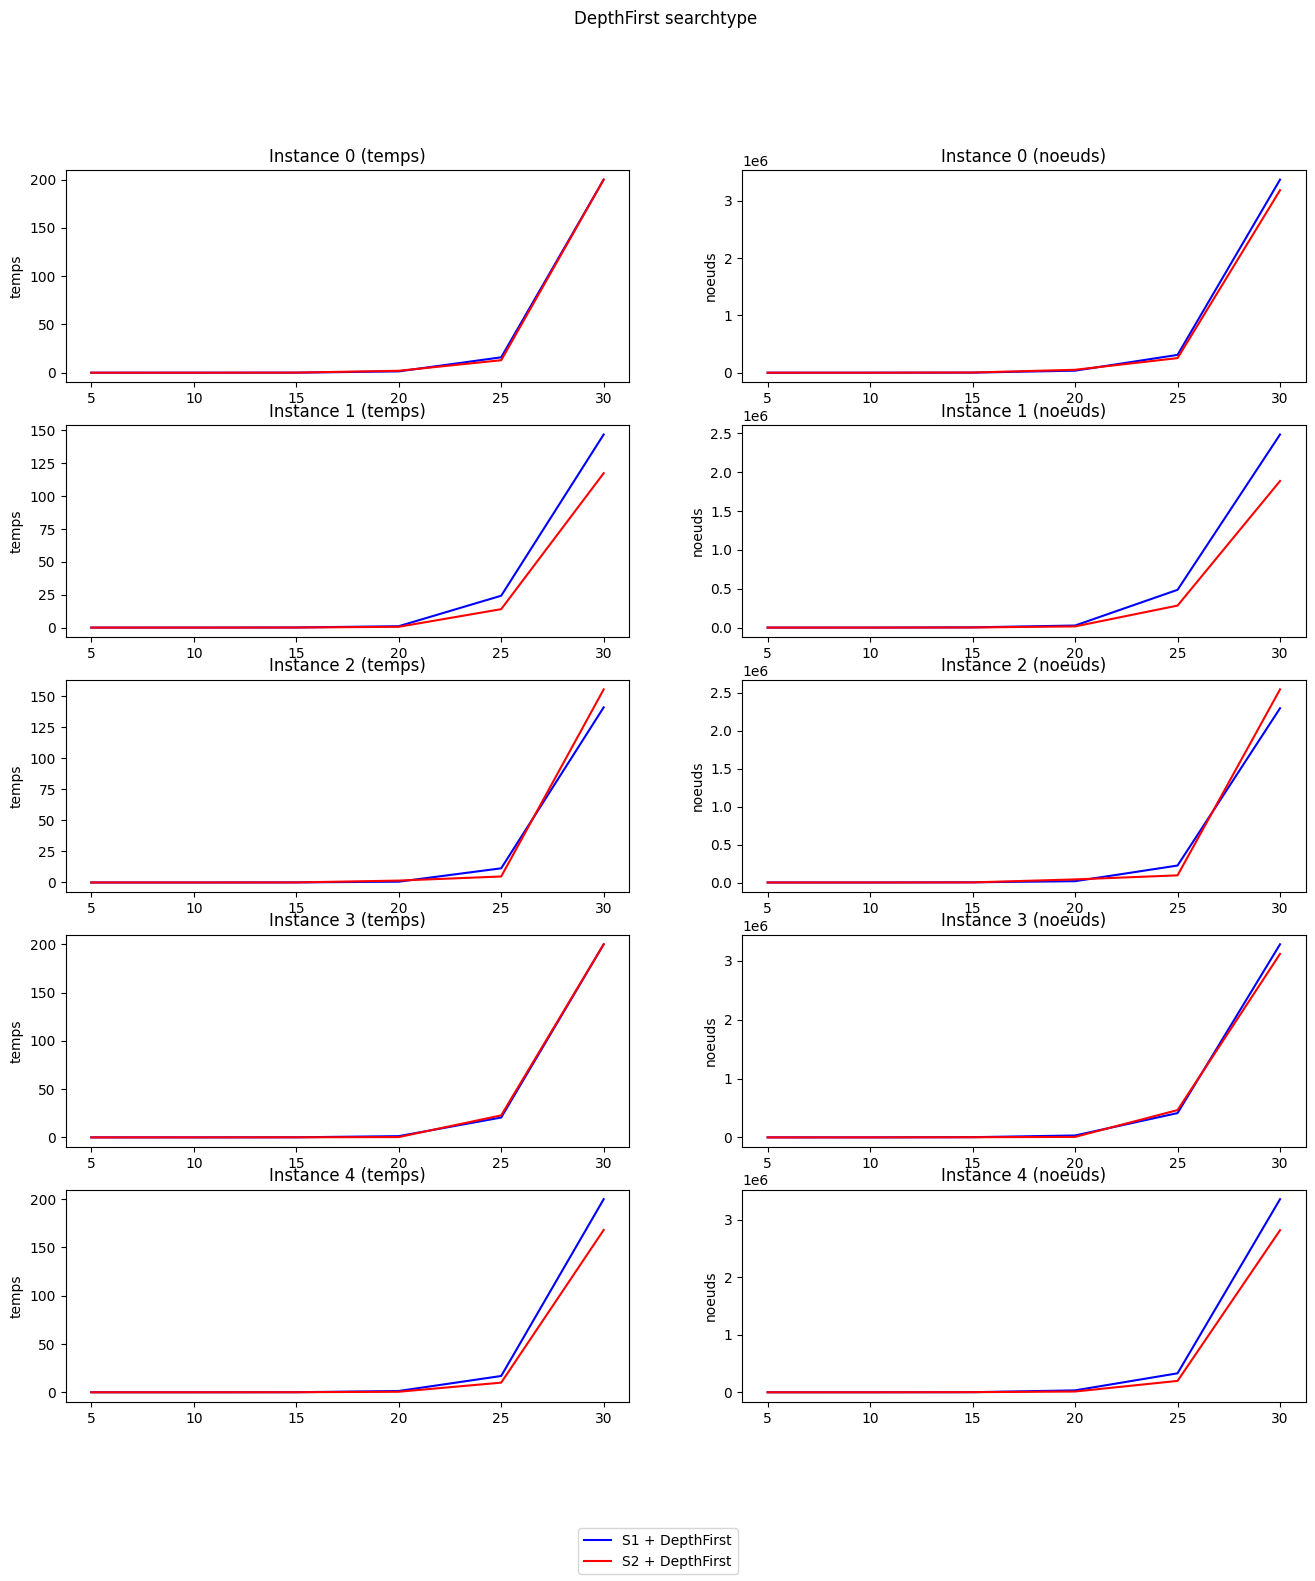

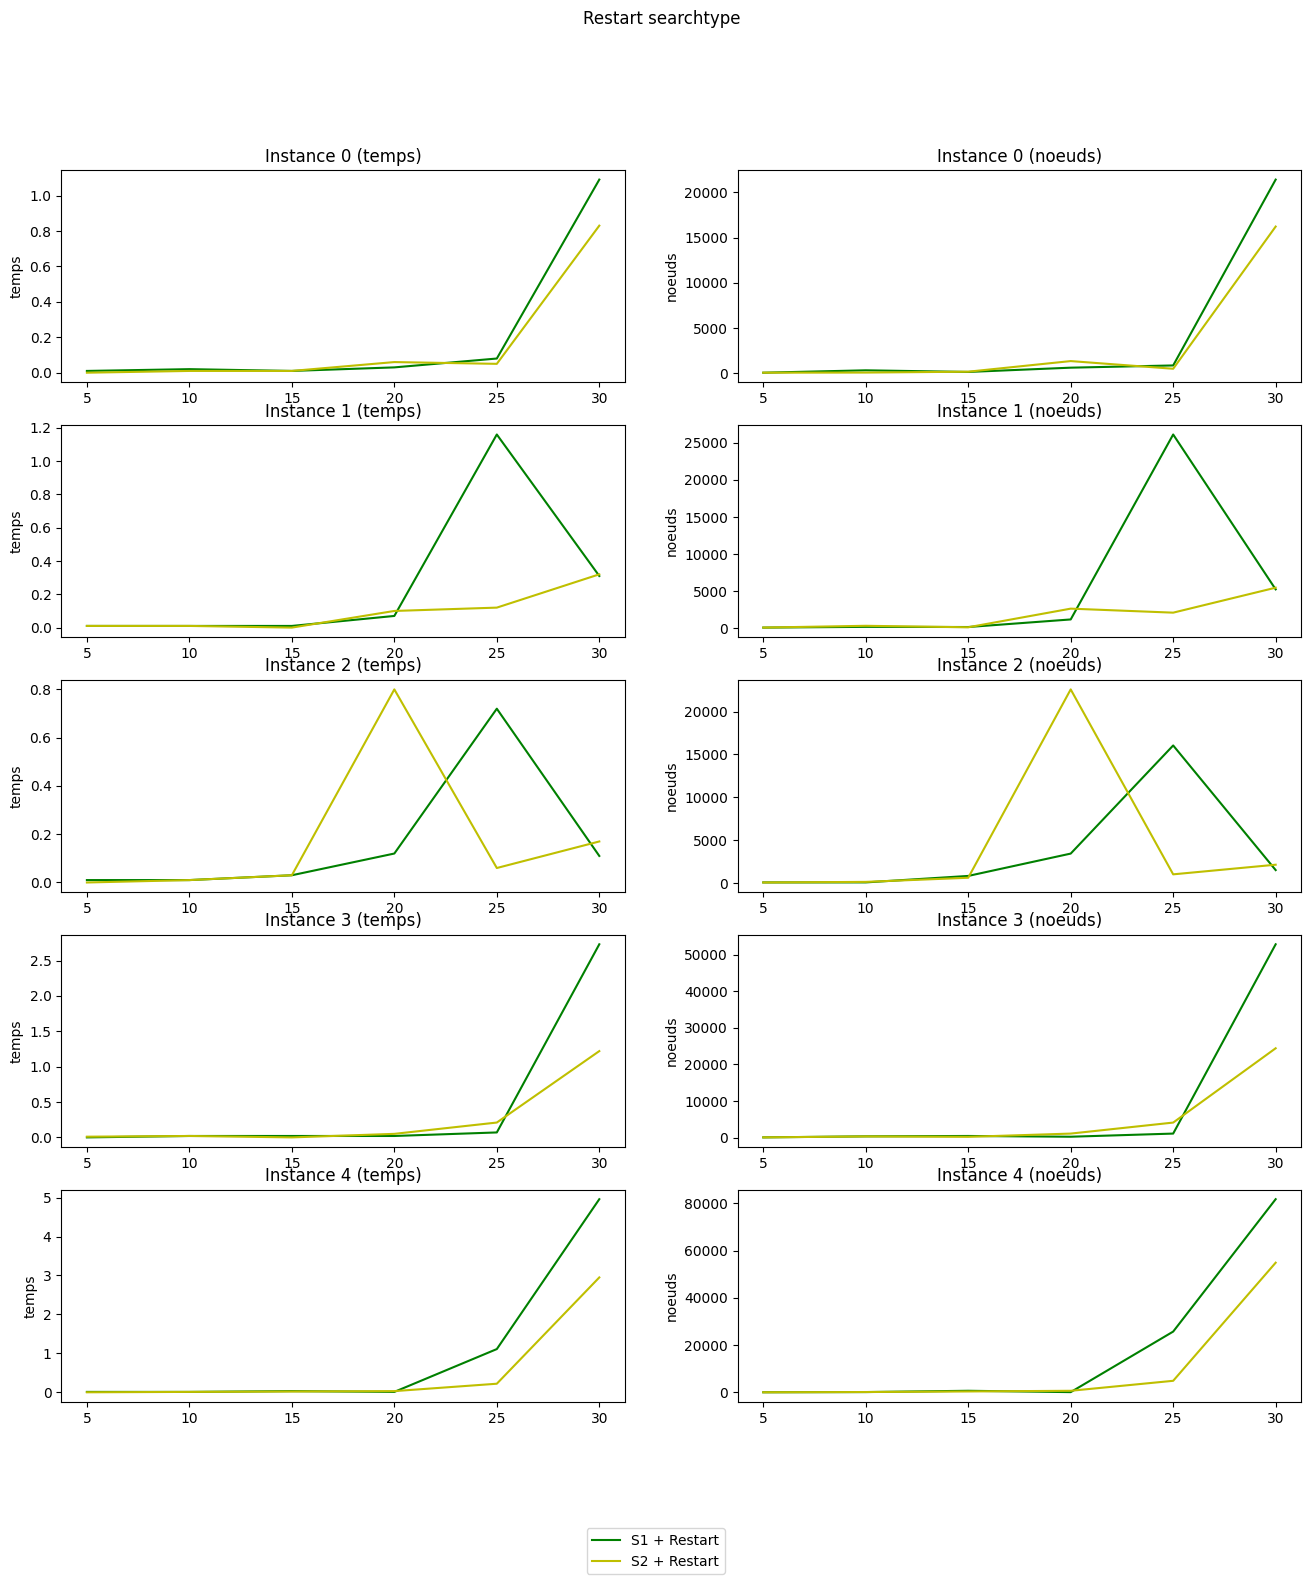

In [20]:
def run(S,type,F,H,L):
    mdl = CpoModel(name="Mariages "+type+" "+S)
    mdl.set_search_phases(strats[S])
    x, D = simple_stable_mariage(mdl,F,H,L)
    solution = mdl.solve(SearchType=type,trace_log=False,TimeLimit=200)
    return (solution.get_solver_infos()['NumberOfChoicePoints'],
    solution.get_solver_infos()['TotalTime'])

#On va dabord choisir les recherches en DepthFirst puis les Restart afin de mieux analyser les différentes stratégies (les ecarts étant trop grands)
#DEPTHFIRST
fig, axs = plt.subplots(5, 2, figsize=(16,16))
lines = {}
for I in range(0,5):
    for strat, color in zip(["S1","S2"],["b","r"]):    
        results_time = []
        results_noeuds = []
        for N in sizes:
            print("Instance",I,"strat",strat,"DepthFirst [Taille =",N,"]")
            noeuds, temps = run(strat,"DepthFirst",*instances[N,I])
            results_time.append(temps)
            results_noeuds.append(noeuds)
        lines[color],=axs[I][0].plot(sizes, results_time, color)
        axs[I][1].plot(sizes, results_noeuds, color)
    axs[I][0].set_ylabel("temps")
    axs[I][1].set_ylabel("noeuds")
    axs[I][0].set_title("Instance "+str(I)+" (temps)")
    axs[I][1].set_title("Instance "+str(I)+" (noeuds)")

plt.figlegend([lines['b'],lines['r']],["S1 + DepthFirst","S2 + DepthFirst"],loc = 'lower center')
fig.suptitle('DepthFirst searchtype')

#RESTART
fig, axs = plt.subplots(5, 2, figsize=(16,16))
lines = {}
for I in range(0,5):
    for strat, color in zip(["S1","S2"],["g","y"]):    
        results_time = []
        results_noeuds = []
        for N in sizes:
            print("Instance",I,"strat",strat,"Restart [Taille =",N,"]")
            noeuds, temps = run(strat,"Restart",*instances[N,I])
            results_time.append(temps)
            results_noeuds.append(noeuds)
        lines[color],=axs[I][0].plot(sizes, results_time, color)
        axs[I][1].plot(sizes, results_noeuds, color)
    axs[I][0].set_ylabel("temps")
    axs[I][1].set_ylabel("noeuds")
    axs[I][0].set_title("Instance "+str(I)+" (temps)")
    axs[I][1].set_title("Instance "+str(I)+" (noeuds)")

plt.figlegend([lines['g'],lines['y']],["S1 + Restart","S2 + Restart"],loc = 'lower center')
fig.suptitle('Restart searchtype')



* Quelles sont vos conclusions ?

> * On peut voir que en générale, la recherche par restart est bien plus intérésante et qu'elle génère des temps de recherche en moyenne 100 fois moins importants et des nombre de noeuds en moyenne 20 à 100 fois moins importants.
> * On a nottament les instances 1 et 3 qui n'ont pas pu finir pour leurs instances de 30 couples en depthfirst
> * On observe une tendance exponentielle des temps de recherche et des nombres de noeuds en depthfirst
> * Concernant les stratégies, la stratégies S2 (random var random value) semble plus intéressante concernant le depthfirst et égalemnt pour le Restart même si cela dépend des instances

## Deuxième partie


##### 1. Proposez un modèle pour ce problème d’optimisation et testez le avec l’exemple précédant (ou autres exemples). N’affichez pas les traces d’exécutions internes du solveur.

In [21]:
def add_equity_opti(mdl,D,H,F):
    #On rajoute les variables DH et DF qui représentent les pires satisfaction respectives des hommes et femmes
    DH = mdl.integer_var(name="DH")
    DF = mdl.integer_var(name="DF")

    #On attribue les valeurs de DH et DF comme les maxs de D[h] et D[f]
    mdl.add(DH==max([D[h] for h in H]))
    mdl.add(DF==max([D[f] for f in F]))
    mdl.add(minimize(abs(DH-DF)))

    return DH,DF

In [20]:

def print_equity_solution(solution,x,D,DH,DF):
    print_solution(solution,x,D)
    print("\nDF = ",solution[DF])
    print("DH = ",solution[DH])


##### 2. En utilisant les instances générées dans la première partie, évaluez les deux stratégies S1 et S2 avec uniquement une recherche en profondeur sans redémarrage (DepthFirst). Cette fois, on cherche la meilleure solution dans la limite de 200s par exécution. Présentez vos résultats sous forme de figures qui représentent le temps de résolution ainsi que la qualité des solutions (i.e., en se basant sur la meilleure valeur) en fonction de la taille de la donnée.

Instance 0 strat S1 [Taille = 5 ]
Instance 0 strat S1 [Taille = 10 ]
Instance 0 strat S1 [Taille = 15 ]
Instance 0 strat S1 [Taille = 20 ]
Instance 0 strat S1 [Taille = 25 ]
Instance 0 strat S1 [Taille = 30 ]


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

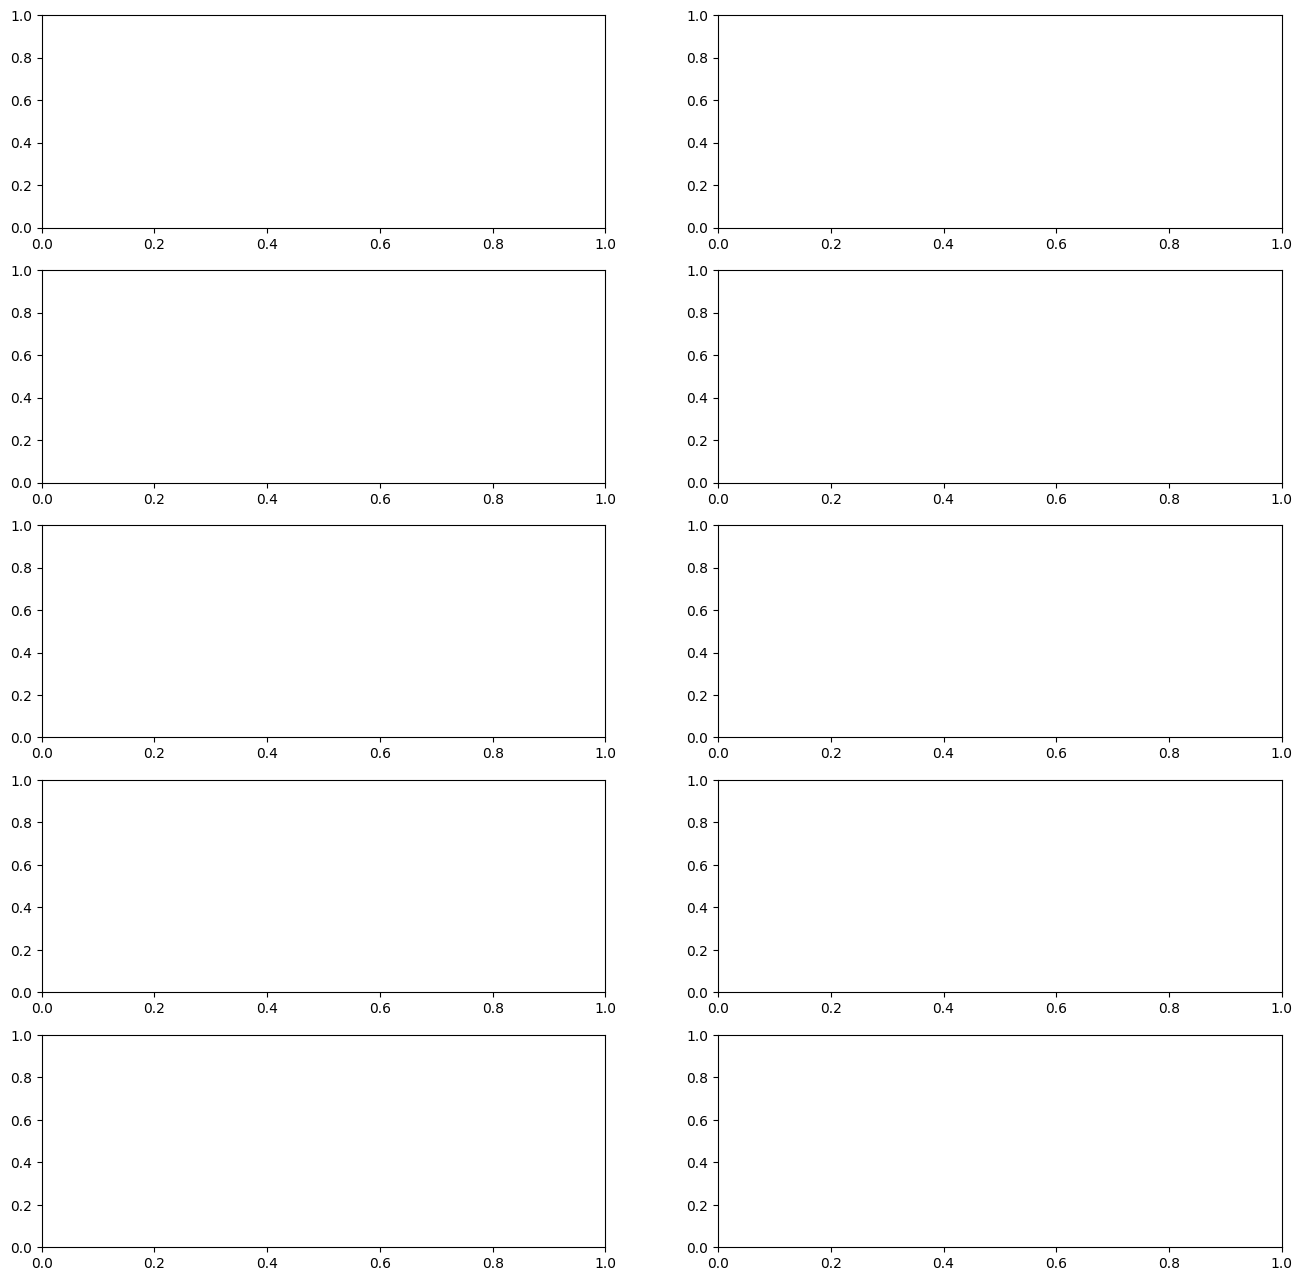

In [25]:
def run(S,F,H,L):
    mdl = CpoModel(name="Mariages equitables "+S)
    mdl.set_search_phases(strats[S])
    x, D = simple_stable_mariage(mdl,F,H,L)
    DH, DF = add_equity_opti(mdl,D,H,F)
    solution = mdl.solve(SearchType="DepthFirst",trace_log=False,TimeLimit=200)
    if (solution==None):
        return 200, None
    return (solution.get_solver_infos()['TotalTime'],abs(solution[DF]-solution[DH]))

#On va dabord choisir les recherches en DepthFirst puis les Restart afin de mieux analyser les différentes stratégies (les ecarts étant trop grands)
#DEPTHFIRST
fig, axs = plt.subplots(5, 2, figsize=(16,16))
lines = {}
for I in range(0,5):
    for strat, color in zip(["S1","S2"],["b","r"]):    
        results_time = []
        results_qual = []
        for N in sizes:
            print("Instance",I,"strat",strat,"[Taille =",N,"]")
            temps, qual= run(strat,*instances[N,I])
            results_time.append(temps)
            results_qual.append(qual)
        lines[color],=axs[I][0].plot(sizes, results_time, color)
        axs[I][1].plot(sizes, results_qual, color)
    axs[I][0].set_ylabel("temps")
    axs[I][1].set_ylabel("Différence de rang")
    axs[I][0].set_title("Instance "+str(I)+" (temps)")
    axs[I][1].set_title("Instance "+str(I)+" (Ecart pire satisfaction H-F)")

plt.figlegend([lines['b'],lines['r']],["S1 + DepthFirst","S2 + DepthFirst"],loc = 'lower center')


[None, None]